### 匯入函式庫

In [1]:
# 事前準備
import os
import numpy as np          # 資料處理分析工具
import pandas as pd         # 資料處理分析工具
from scipy import stats     # 統計函式庫
from scipy.stats import norm, skew
from collections import Counter # counter是字典，用來計數，key是要計數的item，value儲存的是個數
from sklearn.preprocessing import LabelEncoder # 用於特徵提取, 將數值資料轉為離散
from sklearn.preprocessing import MinMaxScaler

# 匯入必要的函式庫
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

import datetime as dt
import string
from google.cloud import bigquery

# 資料視覺化
import matplotlib.pyplot as plt
from matplotlib import rcParams, pyplot as plt, style as style
%matplotlib inline
import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
# 設定展示欄位最大值
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)

# 忽略警告
import warnings
warnings.filterwarnings("ignore")

### 確認資料

In [2]:
calendar = pd.read_csv('.\data\Seattle Airbnb Open Data\calendar.csv')

calendar.head()

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,68396,2020-06-01,f,"$1,498.00","$1,498.00",7.0,365.0
1,271733,2020-06-02,f,$800.00,$800.00,5.0,182.0
2,271733,2020-06-03,f,$800.00,$800.00,5.0,182.0
3,271733,2020-06-04,f,$800.00,$800.00,5.0,182.0
4,271733,2020-06-05,f,$800.00,$800.00,5.0,182.0


In [3]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3069763 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype  
---  ------          -----  
 0   listing_id      int64  
 1   date            object 
 2   available       object 
 3   price           object 
 4   adjusted_price  object 
 5   minimum_nights  float64
 6   maximum_nights  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 163.9+ MB


#### 檢查最早到最後的時間
- 確認資料為一年的時間

In [4]:
calendar.date.min(), calendar.date.max()

('2020-05-31', '2021-06-02')

#### 檢查缺失值

In [5]:
calendar.isnull().sum()

listing_id          0
date                0
available           0
price               0
adjusted_price      0
minimum_nights    453
maximum_nights    453
dtype: int64

#### 因為數據量夠大, 因此直接drop掉

In [6]:
calendar = calendar.dropna()

#### 將 date 這種時間格式進行轉換

In [7]:
calendar['date'] = pd.to_datetime(calendar['date'])

calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069310 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           object        
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(2), int64(1), object(3)
memory usage: 187.3+ MB


#### 處理 price 價格特徵 object
- 解決他有字串又有數字的 object 類型
- astype做型態轉換

In [8]:
calendar['price'] = calendar['price'].str.replace('$','') # 移除錢字號
calendar['price'] = calendar['price'].str.replace(',','') # 移除逗號

# astype做型態轉換
calendar['price'] = calendar['price'].astype(float)
calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3069310 entries, 0 to 3069762
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   listing_id      int64         
 1   date            datetime64[ns]
 2   available       object        
 3   price           float64       
 4   adjusted_price  object        
 5   minimum_nights  float64       
 6   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(2)
memory usage: 187.3+ MB


#### 提取時間中我需要的指標
- 利用 groupby 取得群體
- 利用 .dt.strftime('%B') 得到月份群體
- 發現 四五六月是旺季

<AxesSubplot:ylabel='date'>

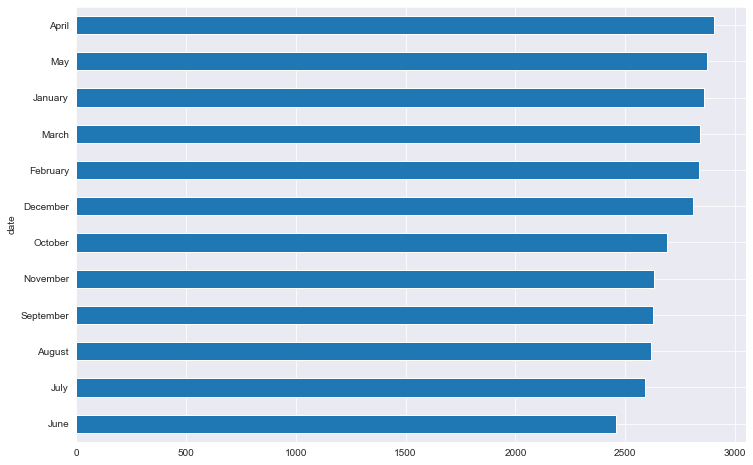

In [9]:
mean_of_mouth = calendar.groupby(calendar['date'].dt.strftime('%B'))['price'].mean()

# 圖示化各月份的價格平均
mean_of_mouth.sort_values(ascending=True,inplace=True)
mean_of_mouth.plot(kind='barh',figsize=(12,8))

#### 新增一個特徵為 (星期 dayofweek)
- 使用 .dt.day_name() 可以從 date資料取得星期資料
- 發現 星期五六 價格最高

<AxesSubplot:xlabel='dayofweek'>

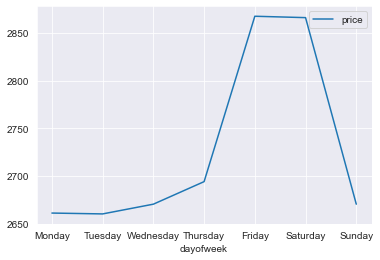

In [10]:
# 新增一個特徵
calendar['dayofweek'] = calendar.date.dt.day_name()

# 建立星期 index
cats = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

# 取得每天平均的各特徵資料
calendar.groupby(['dayofweek']).mean()

# 將日期index重新排列, 建立一個群組
price_week = calendar.groupby(['dayofweek']).mean().reindex(cats)

# 沒有必要的特徵 就拿掉
price_week.drop('listing_id',axis=1, inplace = True)
price_week.drop('minimum_nights',axis=1, inplace = True)
price_week.drop('maximum_nights',axis=1, inplace = True)

# 劃出當前結果
price_week.plot()

### 房間資訊
- listing 只包含房間的資訊

In [18]:
listings = pd.read_csv('.\data\Seattle Airbnb Open Data\listings.csv',encoding='latin1')
# listings.head()

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xa1 in position 2752: invalid start byte

#### 觀察一下評分
- 看得出來大部分的人都給好評 台北的房子不錯

In [ ]:
plt.figure(figsize=(12,6))
sns.distplot(listings.review_scores_rating.dropna())
sns.despine()
plt.show()

# 看一下評分的描述
listings.review_scores_rating.describe()

#### 觀察一下房價
- 平均兩千五台幣

In [ ]:
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings['price'].describe()

#### 根據房價進行排序
- 可以看到最貴的房間樣式

In [ ]:
high_price = listings.sort_values('price',ascending=False)
high_price.head(3)

In [ ]:
# 取得房價 1000 ~ 5000 的資料 
# 繪製成直方圖
listings.loc[(listings['price'] <= 5000) & (listings['price'] > 1000)].price.hist(bins=50)

#### 利用 boxplot 針對各種"房型"確認離群值
- 可以看出 Entire home 和 Hotel room 最貴
- boxplot() data為要判斷的數據
- 圖上方的黑點為離群點

In [ ]:
f,ax = plt.subplots(figsize=(14,10))
sns.boxplot(y='price',x='room_type',data=listings.loc[(listings['price']<=5000) & (listings['price']>1000)])

#### 確認房內設施
- 電視, 網路WIFI等等....
- 將各種設施獨立取出並做統計

In [ ]:
listings.amenities[:5]

# 移除設施特徵那些奇怪的東西
listings.amenities = listings.amenities.str.replace('[{}]','').str.replace('"','')

listings.amenities[:5]

In [ ]:
# 針對設施做變換操作 對 amns 執行每個字串根據逗號做list變換
listings['amenities'].map(lambda amns:amns.split(','))[:5]

In [ ]:
# np.concatenate 可以做 list 拼接
np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))

In [ ]:
# 前十個最常見的設施 : 冷氣, wifi, 吹風機....
print(pd.Series(np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))).value_counts().head(10))

f,ax = plt.subplots(figsize=(14,10))
pd.Series(np.concatenate(listings['amenities'].map(lambda amns:amns.split(',')))).value_counts().head(10).plot(kind='bar')

### 特徵前處理
- 確認一下在房價1000~5000中 廁所與房間的關係
- 統計 'bathrooms 數量' 和 'bedrooms 數量' 的關係
- .pivot('上方row', '左方 column', 'value 統計的是price的指標')
- 發現一個(房間bedrooms)一個(廁所bathrooms)的房間最多!
- 發現六個房間六個廁所最貴!

In [ ]:
# 數值特徵列
col = ['host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'number_of_reviews', 'review_scores_rating', 'reviews_per_month']

In [ ]:
# 根據房間數與廁所數計數 count()

cur_input = listings.loc[(listings['price']<=5000) & (listings['price']>0)].groupby(['bathrooms','bedrooms']).count()['price'].reset_index().pivot('bathrooms','bedrooms','price')

cur_input

In [ ]:
# 房間數量可視化
#  fmt='.0f' 將科學記號轉數值
f,ax = plt.subplots(figsize=(14,10))
sns.heatmap(cur_input,cmap='Oranges',annot=True,linewidths=0.5, fmt='.0f')

In [ ]:
# 取平均值而非計數 mean()

mean_input = listings.loc[(listings['price']<=5000) & (listings['price']>0)].groupby(['bathrooms','bedrooms']).mean()['price'].reset_index().pivot('bathrooms','bedrooms','price')

mean_input

In [ ]:
# 房間數量可視化
#  fmt='.0f' 將科學記號轉數值
f,ax = plt.subplots(figsize=(14,10))
sns.heatmap(mean_input,cmap='Oranges',annot=True,linewidths=0.5, fmt='.0f')

### 建立模型
- 重新讀取房間資訊資料, 並作前處理
- 將部分特徵資訊, 含有t & f 的 做些0、1轉換 (true/false => 0/1)

In [ ]:
listings = pd.read_csv('.\data\Seattle Airbnb Open Data\listings.csv')
listings['price'] = listings['price'].str.replace('$','')
listings['price'] = listings['price'].str.replace(',','')
listings['price'] = listings['price'].astype(float)
listings = listings.loc[(listings['price'] <= 10000) & (listings['price'] > 0)] # 過濾離群值
listings.amenities = listings.amenities.str.replace('[{}]','').str.replace('"','')

In [ ]:
columns =  ['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic',
                   'is_location_exact', 'requires_license', 'instant_bookable',
                   'require_guest_profile_picture', 'require_guest_phone_verification']
for c in columns:
    listings[c] = listings[c].replace('f',0,regex=True)
    listings[c] = listings[c].replace('t',1,regex=True)

In [ ]:
# 針對部分特徵 做 nan 補 0
# 移除特殊字元並轉成float格式

listings['security_deposit'] = listings['security_deposit'].fillna(value=0)
listings['security_deposit'] = listings['security_deposit'].replace( '[\$,)]','', regex=True ).astype(float)
listings['cleaning_fee'] = listings['cleaning_fee'].fillna(value=0)
listings['cleaning_fee'] = listings['cleaning_fee'].replace( '[\$,)]','', regex=True ).astype(float)

In [ ]:
listings_new = listings[['host_is_superhost', 'host_identity_verified', 'host_has_profile_pic','is_location_exact', 
                         'requires_license', 'instant_bookable', 'require_guest_profile_picture', 
                         'require_guest_phone_verification', 'security_deposit', 'cleaning_fee', 
                         'host_listings_count', 'host_total_listings_count', 'minimum_nights',
                     'bathrooms', 'bedrooms', 'guests_included', 'number_of_reviews','review_scores_rating', 'price']]

for col in listings_new.columns[listings_new.isnull().any()]:
    print(col)
    
for col in listings_new.columns[listings_new.isnull().any()]:
    listings_new[col] = listings_new[col].fillna(listings_new[col].median())
    
# 做 one-hot encoding    
for cat_feature in ['zipcode', 'property_type', 'room_type', 'cancellation_policy', 'neighbourhood_cleansed', 'bed_type']:
    listings_new = pd.concat([listings_new, pd.get_dummies(listings[cat_feature])], axis=1)

In [ ]:
#listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')

In [ ]:
listings_new.head()

### random forest 建模
- 我們要預測房屋價格

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score # 越接近1 代表訓練結果越好
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score

In [ ]:
# y 代表 要預測的值
y = listings_new['price']

# x 代表 除了要預測的值
x = listings_new.drop('price',axis=1)

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1)

In [ ]:
# 將資料做標準化
from sklearn.preprocessing import StandardScaler ,MinMaxScaler

#std = StandardScaler()
std = MinMaxScaler()
X_fit = std.fit(X_train)
X_train = X_fit.transform(X_train)
X_test = X_fit.transform(X_test)

In [ ]:
rf = RandomForestRegressor(n_estimators=1000,n_jobs=-1)
rf.fit(X_train, y_train)
y_train_predict = rf.predict(X_train)
y_test_predict = rf.predict(X_test)
rmse_rf = mean_squared_error(y_test,y_test_predict)**(1/2)

rmse_rf

In [ ]:
r2_score(y_train,y_train_predict)

In [ ]:
r2_score(y_test,y_test_predict)

### LightGBM 建模
- 我們要預測房屋價格

In [ ]:
from lightgbm import LGBMRegressor

In [ ]:
fit_params ={'early_stopping_rounds':10,
            'eval_metric':'rmse',
            'eval_set':[(X_test,y_test)],
            'eval_names':['valid'],
            'verbose':100}

import lightgbm as lgb
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [ ]:
lgb = LGBMRegressor(max_depth=20,learning_rate =0.01,n_estimators=1000)

model_lgb.fit(X_train,y_train,**fit_params)

In [ ]:
y_pred_test = model_lgb.predict(X_test)
y_pred_train = model_lgb.predict(X_train)

In [ ]:
r2_score(y_test,y_pred_test)

In [ ]:
r2_score(y_train,y_pred_train)